In [ ]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

In [23]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

def solveEquation(equation, x):
    kicks = np.arange(0, 100, 0.01).tolist() + np.arange(-100, -1, 0.01).tolist() 
    np.random.seed(42), np.random.shuffle(kicks)
    val = None
    
    for kick in ([0, 1, -1] + kicks):
        try:
            val = float(sp.nsolve(equation, x, kick))
            if not np.isnan(val): return val
        except:
            continue
    return None

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [24]:
s = ctl.TransferFunction.s
G = 2250/(s**2 + 21.89*s + 2291)
G_bkp = G
G

TransferFunction(array([2250]), array([1.000e+00, 2.189e+01, 2.291e+03]))

polos:  (-10.945+46.596j) (-10.945-46.596j)
zeros: 


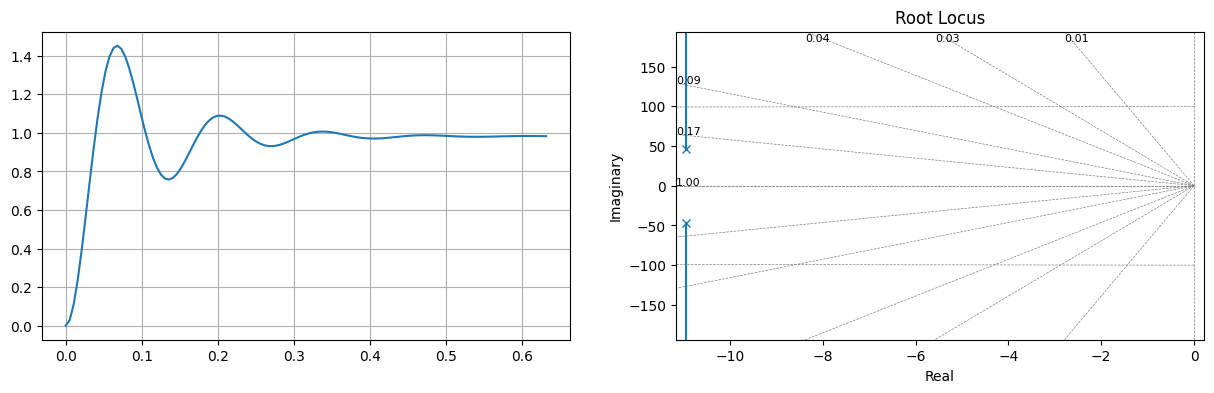

In [25]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

In [26]:
ctl.step_info(G)

{'RiseTime': 0.026079893377413496,
 'SettlingTime': 0.35468654993282356,
 'SettlingMin': 0.7577649011811073,
 'SettlingMax': 1.4515704328278805,
 'Overshoot': 47.80212718260774,
 'Undershoot': 0,
 'Peak': 1.4515704328278805,
 'PeakTime': 0.0678077227812751,
 'SteadyStateValue': 0.9821038847664775}

# REQUISITOS DO SISTEMA
- Os requisitos do sistema serão encontrados a partir do overshoot e tempo de establização máximos permitidos

(0.5911550337988976, 33.83207256390159, -20.0 + 27.288*I)

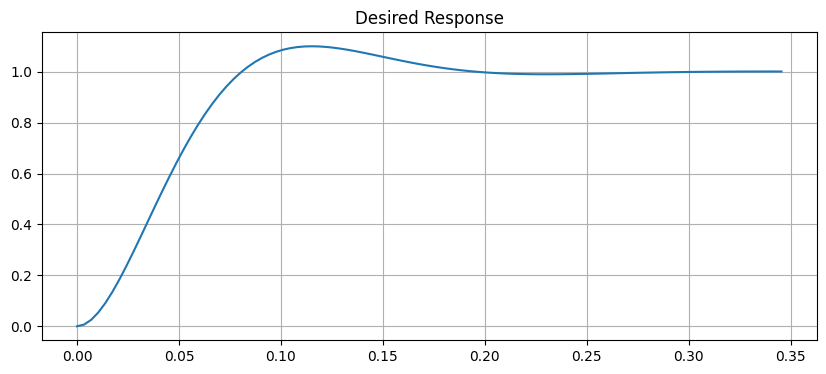

In [27]:
Ts = 0.2
UP = 0.1

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K\cdot\frac{s-a}{s}$
- $p$ é um polo colocado arbitrariamente pois o número de polos tem que ser maior ou igual o número de zeros. Esse polo $p$ precisa estar longe do eixo imaginário para que tenha pouca influência no sistema

In [28]:
s = sp.symbols('s')
K, a = sp.symbols('K a', real=True)

C = K * (s - a)
C

K*(-a + s)

In [29]:
GC = sympyFunction(G) * C
GC

2250*K*(-a + s)/(1.0*s**2 + 21.89*s + 2291.0)

### EQUAÇÃO 1 - SOMA DOS ÂNGULOS
- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [30]:
G_aux = GC.subs(K, 1).subs(s, s_d).simplify()
angle = sp.arg(G_aux)
angle = roundSympyFunction(angle)

eq = sp.Eq(angle + sp.pi, 0)
eq

Eq(arg(-1.346939*a - 0.441239*I*a - 38.979322 + 27.9305*I) + pi, 0)

In [31]:
a_desired = float(sp.re(s_d))
#a_desired = solveEquation(eq, a)
a_desired

-20.0

In [32]:
GC = GC.subs(a, a_desired)
a  = a_desired
GC

2250*K*(s + 20.0)/(1.0*s**2 + 21.89*s + 2291.0)

### EQUAÇÃO 3 - MÓDULO
- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [33]:
G_aux  = GC.subs(s, s_d).simplify()
modulo = sp.Abs(G_aux).expand().simplify()
modulo = roundSympyFunction(modulo)

eq = sp.Eq(modulo - 1, 0)
eq

Eq(38.677193*Abs(K) - 1, 0)

In [34]:
K = solveEquation(eq, K)
K

0.025855030388623936

# RESPOSTA CONTROLADA

In [35]:
s = ctl.TransferFunction.s
C = K * (s - a)

print(sympyFunction(C))
C

0.0258550303886239*s + 0.517100607772479


TransferFunction(array([0.02585503, 0.51710061]), array([1]))

In [36]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([  58.17381837, 1163.47636749]), array([1.000e+00, 2.189e+01, 2.291e+03]))

In [37]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([  58.17381837, 1163.47636749]), array([1.00000000e+00, 8.00638184e+01, 3.45447637e+03]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (-40.032+43.034j) (-40.032-43.034j)
zeros:  (-20+0j)


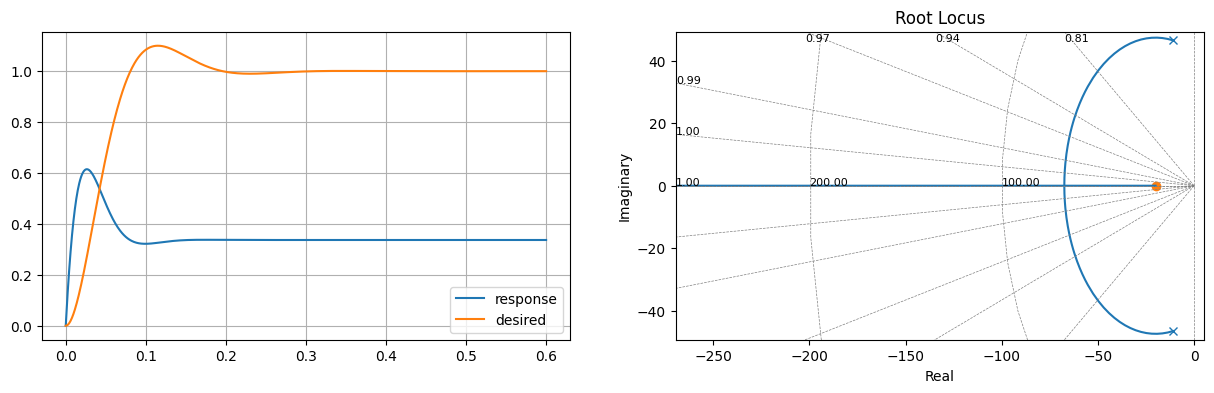

In [39]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 3*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [40]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor finalroundSympyFunction(: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.8256114466802364
valor de pico:  0.6148705472447129
tempo de pico:  0.026426426426426432
tempo de assentamento:  0.12552552552552554
valor finalroundSympyFunction(:  0.3368025262784245
erro:  0.6631974737215756


# APLICANDO VÁRIOS STEPS

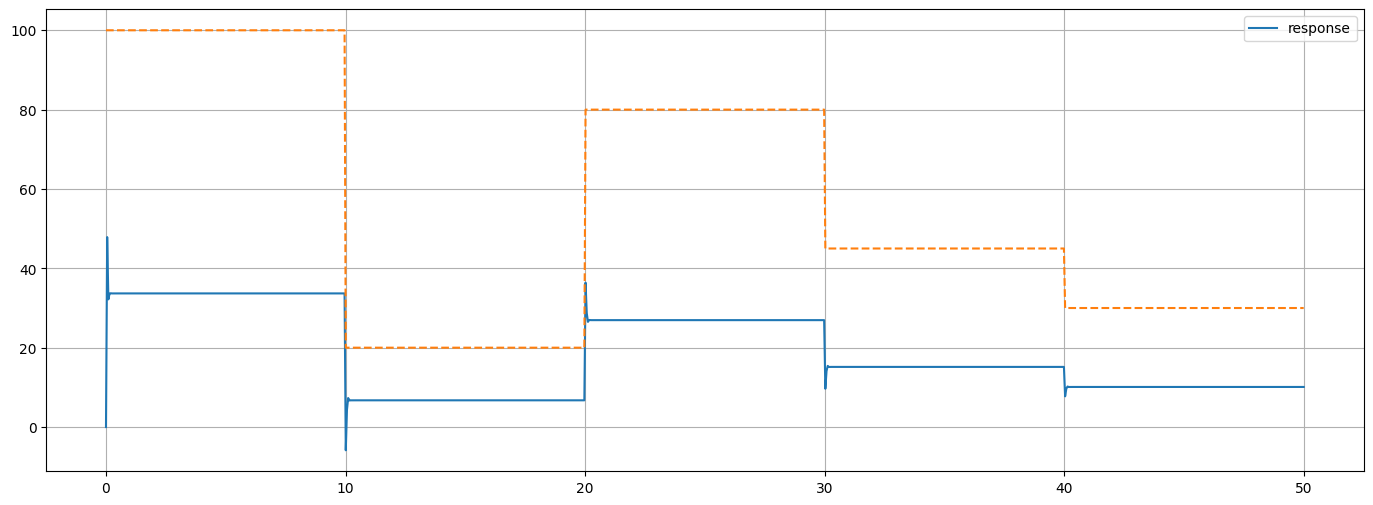

In [41]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()